# Peg Keeper Death Spiral Simulation

Here we create a Peg Keeper object for each existing Peg Keeper, and hook it on to an existing StableSwap pool using Curvesim. Then we simulate agents acting against these Peg Keepers and pools based on some input market prices.

The specific input we are studying in this notebook is if the market price for one of the four peg keeper tokens depegs.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from curvesim.pool import get_sim_pool
import numpy as np
from src.modules.pegkeeperv1 import PegKeeperV1
from src.modules.aggregator import AggregateStablePrice
from src.agents.arbitrageur import Arbitrageur
from src.utils.plotting import plot_stableswap_balances, make_gif
from src.utils.plotting import fn_frames_stableswap_bals, fn_gif_stableswap_bals
import matplotlib.pyplot as plt

In [3]:
USDC_POOL = "0x4DEcE678ceceb27446b35C672dC7d61F30bAD69E"
USDT_POOL = "0x390f3595bca2df7d23783dfd126427cceb997bf4"
USDP_POOL = "0xca978a0528116dda3cba9acd3e68bc6191ca53d0"
TUSD_POOL = "0x34d655069f4cac1547e4c8ca284ffff5ad4a8db0"

# Aggregator Params
SIGMA = 0.001

# PegKeeper Params
CALLER_SHARE = 0.2
CEILING = 25_000_000 # For USDC/USDT

In [4]:
pools = [get_sim_pool(address, balanced=False) for address in [USDC_POOL, USDT_POOL]]
# pools = {address:get_sim_pool(address, balanced=False) for address in [USDC_POOL, USDT_POOL, USDP_POOL, TUSD_POOL]}
arbitrageur = Arbitrageur(0, True)
agg = AggregateStablePrice(pools, SIGMA)
pks = [PegKeeperV1(pool, agg, CALLER_SHARE, CEILING) for pool in pools]

Goal: Implement a function that determines the profit from moving pool price to some target price, then use scipy's optimize to find the most profitable trade. This should account for external market slippage.

Would be cool to then incorporate this into `curvesim` as a `LiquidityLimitedArbitrage`! However, this would likely result in a surprising amount of work, so let's keep things simple for now.

## Showing that profit maximization is working

0.9979002099790021


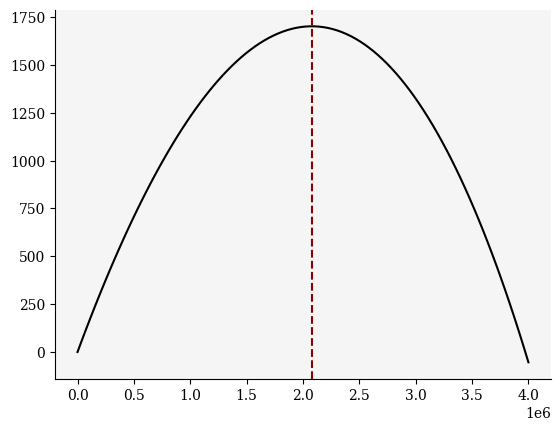

In [5]:
I = 1
PRECISION = 1e18

p_usdc = 0.998
p_usdt = 1.0001
p = p_usdc/p_usdt
prices = [p_usdc, p_usdt] # arbitrary USDC/USDT, USDT/USDC prices
print(p)
amts = np.linspace(0, 4_000_000, 100)
profits = [Arbitrageur.profit(amt_in, pools[0], pools[1], p) for amt_in in amts]
trade = Arbitrageur.search(pools, prices)

plt.plot(amts, profits, color='black')
plt.axvline(trade.size/PRECISION, color='darkred', linestyle='--')

In [6]:
profit = arbitrageur.arbitrage(pools, prices)

Arbitrage trade with profit 1702.


In [7]:
pools_cp = [get_sim_pool(address, balanced=False) for address in [USDC_POOL, USDT_POOL]]
print('Original price from Curve pools:', pools_cp[0].price(0, 1) / pools_cp[1].price(0, 1))
print('Market price:', p)
print('Final price from Curve pools:', pools[0].price(0, 1) / pools[1].price(0, 1))

Original price from Curve pools: 0.9996976214054155
Market price: 0.9979002099790021
Final price from Curve pools: 0.9980999289977566


Notice that the arbitrage process correctly brings the price from the crvUSD pools closer to the prevailing market price for those tokens! This indicates that the logic for our arbitrage is correct. Of course, due to fees and price impact on Curve pools, the prices aren't perfectly equilibrated.

# Testing an Arbitrage Simulation with Peg Keeper

In [8]:
from datetime import datetime
from src.sim.prices import get_prices_df
from curvesim.network.coingecko import coin_ids_from_addresses_sync
from src.utils.utils import get_crvUSD_index

In [9]:
USDC = "0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48"
USDT = "0xdac17f958d2ee523a2206206994597c13d831ec7"

coins = [USDC, USDT]
coins = coin_ids_from_addresses_sync(coins, "mainnet")

start = datetime(2023, 3, 5).timestamp()
end = datetime(2023, 3, 15).timestamp()

df = get_prices_df(coins, start, end)

[DEBUG][14:14:44][urllib3.connectionpool]-8347: Starting new HTTPS connection (1): api.coingecko.com:443
[DEBUG][14:14:44][urllib3.connectionpool]-8347: https://api.coingecko.com:443 "GET /api/v3/coins/usd-coin/market_chart/range?vs_currency=usd&from=1677992400.0&to=1678852800.0 HTTP/1.1" 200 None
[DEBUG][14:14:44][urllib3.connectionpool]-8347: Starting new HTTPS connection (1): api.coingecko.com:443
[DEBUG][14:14:45][urllib3.connectionpool]-8347: https://api.coingecko.com:443 "GET /api/v3/coins/tether/market_chart/range?vs_currency=usd&from=1677992400.0&to=1678852800.0 HTTP/1.1" 200 None


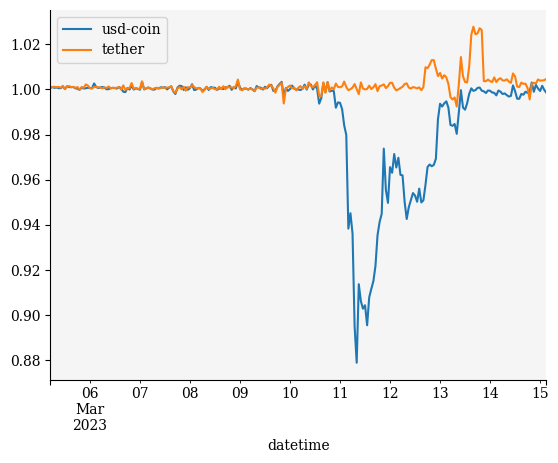

In [10]:
for coin in coins:
    df[coin].plot(label=coin)
plt.legend()

In [11]:
def price_str(pool, crvUSD_is_quote=True):
    idx = get_crvUSD_index(pool)
    if not crvUSD_is_quote:
        idx = idx^1
    coins = pool.metadata['coins']['names']
    return f'{coins[idx^1]}_{coins[idx]}'

def pool_str(pool):
    name = pool.metadata["name"]
    name = name.replace("Curve.fi Factory Plain Pool: ", "")
    name = name.replace("/", "_")
    return name + "_pool"

def price(pool, crvUSD_is_quote=True):
    idx = get_crvUSD_index(pool)
    if not crvUSD_is_quote:
        idx = idx^1
    return pool.price(idx^1, idx)

def bal_str(pool, i):
    _pool_str = pool_str(pool)
    coin = pool.metadata['coins']['names'][i]
    return _pool_str + "_" + coin + "_bal"

In [12]:
"""
Some Metrics
------------
Balances
Price
LP Token Supply
Virtual Price
Arbitrage PnL
Update PnL
Update minted
Update burned
Net unbacked crvUSD
Net PK Profits
Aggregator price
"""

# FIXME PK not updating because:
#   1. It can't burn from USDT pool if it hasn't previously minted.
#   2. It can't mint on USDC pool if p_agg > 1.
# This means the USDC/crvUSD pool is stuck with
# oversupply, and USDT/crvUSD pool is stuck with
# undersupply


for i, row in df.iterrows():
    # FIXME what is the right order for update() vs arbitrage()?

    # arbitrageurs will arbitrage the pools
    prices = np.array(row[coins])
    arbitrage_pnl, arbitrage_count = arbitrageur.arbitrage(pools, prices)
    
    # arbitraguers call the PK.update() function
    update_pnl, update_count = arbitrageur.update(pks, row['timestamp'])

    # Track metrics
    df.loc[i, 'update_pnl'] = update_pnl
    df.loc[i, 'update_count'] = update_count
    df.loc[i, 'arbitrage_pnl'] = arbitrage_pnl
    df.loc[i, 'arbitrage_count'] = arbitrage_count
    df.loc[i, 'p_agg'] = agg.price()

    for pool in pools:
        df.loc[i, price_str(pool)] = price(pool)
        for coin_idx, bal in enumerate(pool.balances):
            df.loc[i, bal_str(pool, coin_idx)] = bal / 1e18

Arbitrage trade with profit 1943.
Arbitrage trade with profit 2.
Arbitrage trade with profit 12.
Arbitrage trade with profit 23.
Arbitrage trade with profit 2.
Arbitrage trade with profit 6.
Arbitrage trade with profit 5.
Arbitrage trade with profit 107.
Arbitrage trade with profit 49.
Arbitrage trade with profit 1043.
Arbitrage trade with profit 61.
Arbitrage trade with profit 737.
Arbitrage trade with profit 3.
Arbitrage trade with profit 1277.
Arbitrage trade with profit 840.
Arbitrage trade with profit 40.
Arbitrage trade with profit 143.
Arbitrage trade with profit 68.
Arbitrage trade with profit 135.
Arbitrage trade with profit 222.
Arbitrage trade with profit 525.
Arbitrage trade with profit 6.
Arbitrage trade with profit 0.
Arbitrage trade with profit 110.
Arbitrage trade with profit 5359.
Arbitrage trade with profit 1239.
Arbitrage trade with profit 740.
Arbitrage trade with profit 88.
Arbitrage trade with profit 195.
Arbitrage trade with profit 176.
Arbitrage trade with profi

In [19]:
# FIXME speed this plotting up. Takes really long ~1.5mins

# balance_cols = [bal_str(p, i) for p in pools for i in range(len(p.balances))]
# ylim = df[balance_cols].max().max() 

# frame = 0
# for i, row in df.iterrows():
#     fn = fn_frames_stableswap_bals.format(frame)
#     bals = np.array(row[balance_cols])
#     _ = plot_stableswap_balances(pools, bals, fn=fn, ylim=ylim)
#     frame += 1

# make_gif(fn_frames_stableswap_bals, fn_gif_stableswap_bals, len(df), fps=10)

<Axes: xlabel='datetime'>

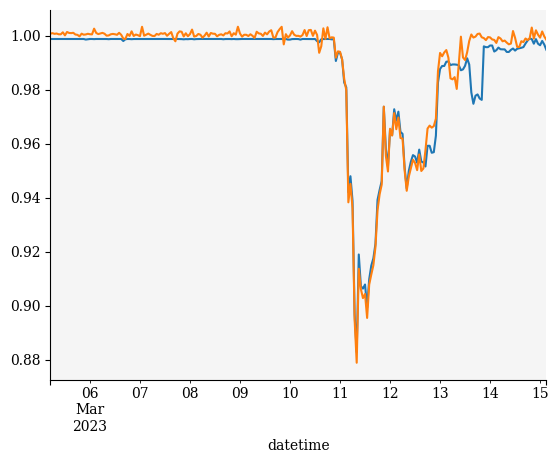

In [21]:
df['p_agg'].plot()
df['usd-coin'].plot()

343214.7629285611

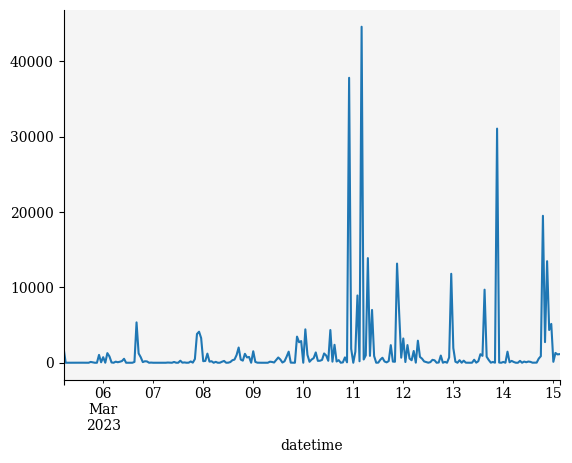

In [15]:
df['arbitrage_pnl'].plot()
df['arbitrage_pnl'].sum()

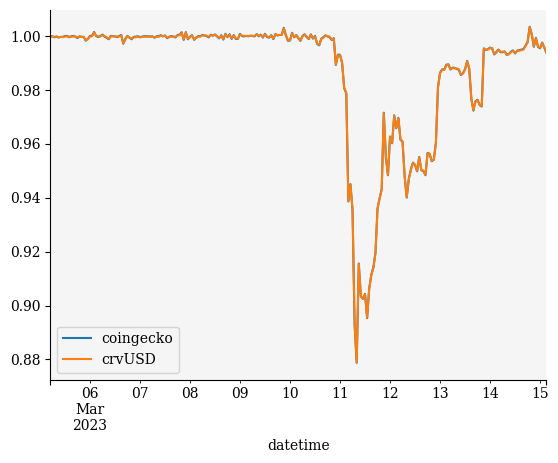

In [16]:
(df['usd-coin'] / df['tether']).plot(label='coingecko')
(df['USDC_crvUSD'] / df['USDT_crvUSD']).plot(label='crvUSD')
plt.legend()

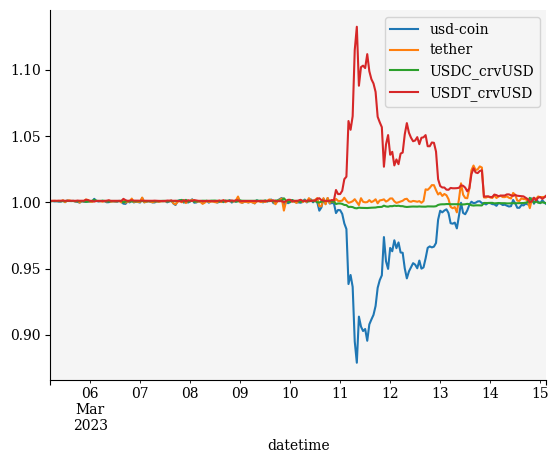

In [17]:
for coin in coins:
    df[coin].plot(label=coin)
df['USDC_crvUSD'].plot(label='USDC_crvUSD')
df['USDT_crvUSD'].plot(label='USDT_crvUSD')
plt.legend()

# Prelim Takeaways

## crvUSD Peg

As USDC depegs, arbitrageurs try selling USDC to the USDC/crvUSD pool, and exchanging it for USDT in the USDT/crvUSD pool. We assume arbitrageurs don't hold crvUSD. Unfortunately, the PKs are unable to maintain crvUSD's peg for two reasons:

1. The PK can't burn crvUSD from the USDT/crvUSD pool, because it never provided any in the first place. That is: the PK can't burn other people's crvUSD.
2. The PK can't mint crvUSD into the USDC/crvUSD pool, because p_agg is below 1 (due to USDT/crvUSD pool). 

The main problem is that demand for the non-depegging token (USDT) skyrockets as USDC depegs, leading to crvUSD being largely underpriced in the USDT/crvUSD pool, and only moderately overpriced in the USDC/crvUSD pool.

## Arbitrageur Profits

We show that arbitrageurs maintain a tight spread between external USDC/USDT price and internal USDC/USDT price on crvUSD pools. For this, they are rewarded with relatively small profits: a total of ~$350K. We currently tally profits in the `token_out`, but this is wrong and should ultimately be converted to USD profits at prevailing market prices.

In [18]:
"""
TODO
1. Understand why update() is never allowed
2. Why does USDT price shoot up by 12% instead of USDC price fall by 8%?
3. Why are arbitrage profits so low? 350k for this weekend seems absurdly little.
4. Create metrics class like in curvesim/
5. Incorporate LPs adding/pulling liquidity?
"""

'\nTODO\n1. Update clearly not working (not being called, and estimate_caller_profit() is broken by the PROFIT_THRESHOLD).\n2. Why does USDT price shoot up by 12% instead of USDC price fall by 8%?\n3. Why are arbitrage profits so low? 350k for this weekend seems absurdly little.\n4. Create metrics class like in curvesim/\n5. Incorporate LPs adding/pulling liquidity?\n'